In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.metrics import mean_squared_error
from typing import Tuple

lucky_7 = 7

random.seed(lucky_7)
np.random.seed(lucky_7)
warnings.filterwarnings("ignore")

def plot_rg(true: np.array, pred: np.array, title: str) -> None:
    max_ = max(true.max(), pred.max())
    plt.figure(figsize=(5,5))
    plt.plot([0, max_], [0, max_], 'r--')
    sns.scatterplot(true, pred, alpha=0.7)
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

def plot_fi(feature_names: np.array, importances: np.array, title: str) -> None:
    # Addition = 1
    if round(importances.sum()) != 1:
        importances = importances / importances.sum()
        print("sum = ", importances.sum())

    # Combine into a DataFrame for easier sorting and plotting
    feat_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances * 100
    }).sort_values(by='Importance', ascending=False)  # ascending=True puts important features at top

    plt.figure(figsize=(10, len(feature_names) * 0.2))
    ax  = sns.barplot(x='Importance', y='Feature', data=feat_df)

    # Add text labels to the right of each bar
    for i, (value, name) in enumerate(zip(feat_df['Importance'], feat_df['Feature'])):
        ax.text(value + 0.001, i, f"{value:.2f}%", va='center')

    plt.title(f"{title} (Horizontal)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_cm(cm):
    plt.figure(figsize=(2.5,2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def compute_folds(X: np.ndarray, y: np.array, folds: int) -> Tuple[np.ndarray, np.ndarray]:
    if folds > len(X):
        raise ValueError(f"{folds} > {len(X)} IMPOSSIBLE")
    
    X_folds = np.array_split(X, folds)
    y_folds = np.array_split(y, folds)

    print(f"Number of folds: {folds}")
    return X_folds, y_folds

def cross_validation(model_class: object, X: np.ndarray, y: np.array, folds: int) -> None:
    X_folds, y_folds = compute_folds(X, y, folds)
    acc_scores = []

    for i in range(folds):
        # Create training data by excluding fold i
        X_train = np.vstack(X_folds[:i] + X_folds[i+1:])
        y_train = np.hstack(y_folds[:i] + y_folds[i+1:])

        # Validation data = fold i
        X_val = X_folds[i]
        y_val = y_folds[i]

        # Reinitialize model to avoid accumulation across folds
        model = model_class()

        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = mean_squared_error(y_val, y_pred)
        acc_scores.append(acc)
        print(f"Fold {i} rmse: {acc:.4f}")

    print(f"\nAverage rmse: {np.mean(acc_scores):.4f}")

### Load the datasets

In [2]:
shhs1_dataset_df = pd.read_csv("shhs1-dataset-0.21.0.csv")
odi_df = pd.read_csv("data/shhs/polysomnography/edfs/shhs1/extracted_122_features.csv")

In [3]:
shhs1_dataset_df = shhs1_dataset_df.set_index("nsrrid")
shhs1_dataset_df.head()

,pptid,ecgdate,lvh3_1,lvh3_3,st4_1_3,st5_1_3,lvhst,mob1,part2deg,mob2,...,eoglqual,chinqual,oximqual,posqual,lightoff,oximet51,monitor_id,headbox_id,rcrdtime,psg_month
nsrrid,,,,,,,,,,,,,,,,,,,,,
200001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,96.0,18.0,18.0,7:16:00,6
200002,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,4,4,NaN,94.0,17.0,17.0,9:00:00,1
200003,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,95.0,17.0,17.0,7:10:00,2
200004,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,3,3,0.0,96.0,19.0,19.0,5:58:00,4
200005,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,0.0,96.0,18.0,18.0,7:57:00,3


In [4]:
odi_df.head()

,nsrrid,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,DD100_sd_thr3,...,PRSAc_win20,PRSAad_win20,PRSAos_win20,PRSAsb_win20,PRSAsa_win20,AC_win20,PSD_total,PSD_band,PSD_ratio,PSD_peak
0,200010,1.714286,29.166667,15.534013,143.958333,68.666603,49.125000,32.619093,6.666667,0.849837,...,-0.397847,1.003945,-0.008350,0.011532,0.029976,205928.626024,0.003211,0.001124,0.350152,0.000300
1,200008,2.428571,25.647059,12.399911,148.827731,63.891156,45.533613,18.285125,7.764706,1.261624,...,-0.346889,1.005636,-0.008298,0.004036,0.026246,203202.518244,0.004651,0.001480,0.318153,0.000512
2,200004,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,7.888889,0.993808,...,-0.369462,1.012658,-0.008772,0.011807,0.017425,202916.418850,0.004051,0.000922,0.227537,0.000326
3,200006,3.571429,40.480000,20.357053,254.280000,121.171455,93.160000,63.307301,8.640000,1.292440,...,-0.369188,0.983493,-0.014594,-0.001052,0.025235,198543.370340,0.007087,0.002098,0.295992,0.000904
4,200007,6.714286,36.978723,16.445253,197.617021,94.168433,83.234043,53.913431,7.127660,1.281904,...,-0.405472,1.060928,-0.021627,-0.010991,0.026964,204047.148179,0.010955,0.003898,0.355867,0.001711


In [5]:
odi_df = odi_df.set_index(odi_df.columns[0])
odi_df.head()

,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,DD100_sd_thr3,DDmax_u_thr3,...,PRSAc_win20,PRSAad_win20,PRSAos_win20,PRSAsb_win20,PRSAsa_win20,AC_win20,PSD_total,PSD_band,PSD_ratio,PSD_peak
nsrrid,,,,,,,,,,,,,,,,,,,,,
200010,1.714286,29.166667,15.534013,143.958333,68.666603,49.125000,32.619093,6.666667,0.849837,3.416667,...,-0.397847,1.003945,-0.008350,0.011532,0.029976,205928.626024,0.003211,0.001124,0.350152,0.000300
200008,2.428571,25.647059,12.399911,148.827731,63.891156,45.533613,18.285125,7.764706,1.261624,3.823529,...,-0.346889,1.005636,-0.008298,0.004036,0.026246,203202.518244,0.004651,0.001480,0.318153,0.000512
200004,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,7.888889,0.993808,4.111111,...,-0.369462,1.012658,-0.008772,0.011807,0.017425,202916.418850,0.004051,0.000922,0.227537,0.000326
200006,3.571429,40.480000,20.357053,254.280000,121.171455,93.160000,63.307301,8.640000,1.292440,4.480000,...,-0.369188,0.983493,-0.014594,-0.001052,0.025235,198543.370340,0.007087,0.002098,0.295992,0.000904
200007,6.714286,36.978723,16.445253,197.617021,94.168433,83.234043,53.913431,7.127660,1.281904,4.021277,...,-0.405472,1.060928,-0.021627,-0.010991,0.026964,204047.148179,0.010955,0.003898,0.355867,0.001711


In [6]:
odi_df.index

Int64Index([200010, 200008, 200004, 200006, 200007, 200003, 200005, 200001,
            200011, 200017,
            ...
            200282, 200280, 200284, 200281, 200285, 200287, 200278, 200283,
            200286, 200288],
           dtype='int64', name='nsrrid', length=277)

### Inner join for datasets based on `nsrr_id`

In [7]:
df = shhs1_dataset_df.merge(right=odi_df, how="inner", left_index=True, right_index=True).loc[:, ["age_s1", "gender", "ahi_o0h3"] + odi_df.columns.tolist()]

In [8]:
print(shhs1_dataset_df.shape[0], odi_df.shape[0], df.shape[0])

5804 277 277


In [9]:
df.head()

,age_s1,gender,ahi_o0h3,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,...,PRSAc_win20,PRSAad_win20,PRSAos_win20,PRSAsb_win20,PRSAsa_win20,AC_win20,PSD_total,PSD_band,PSD_ratio,PSD_peak
nsrrid,,,,,,,,,,,,,,,,,,,,,
200001,55,1,4.314248,3.142857,40.318182,22.475009,323.659091,203.137962,90.068182,84.195699,...,-0.338351,0.986967,-0.009129,0.009058,0.016286,189709.573062,0.006747,0.002047,0.303393,0.000652
200002,78,1,31.318681,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,...,-0.451470,1.730518,-0.056754,-0.023660,-0.005916,193623.447998,0.026928,0.012601,0.467954,0.004824
200003,77,2,8.870293,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,...,-0.424613,1.009535,-0.015965,0.009800,0.029852,200531.372783,0.008494,0.003076,0.362082,0.000906
200004,48,1,2.990033,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,...,-0.369462,1.012658,-0.008772,0.011807,0.017425,202916.418850,0.004051,0.000922,0.227537,0.000326
200005,66,2,6.000000,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,...,-0.404609,1.006716,-0.014427,0.006453,0.025546,197759.891266,0.007806,0.002634,0.337397,0.000802


### Choose of Target Variable

#### 1. `ahi_o0h3`

* Counts **obstructive apneas** with **no oxygen desaturation threshold**, with or without arousal.
* Counts **hypopneas** that have both:

  * \> 30% flow reduction for mare than $n$ $seconds$ (say $10s$)
  * **AND** ≥3% oxygen desaturation
  * With or without arousal.
* The formula:

  $\text{AHI} = \frac{\text{(n obstructive apneas) + (n hypopneas meeting criteria)}}{\text{hours of sleep}}$

#### 2. `ahi_o0h3a`

* Counts **obstructive apneas** same as above.
* Counts **hypopneas** that have:

  * \> 30% flow reduction for mare than $n$ $seconds$ (say $10s$)
  * **AND** either:

    * ≥3% oxygen desaturation **OR**
    * Presence of arousal
* So this is a bit broader in the hypopnea count because it includes events with desaturation **or** arousal (not necessarily both).

`≥3% oxygen desaturation`: this means the blood oxygen saturation (SpO₂) level drops by 3% or more from the baseline during a breathing event (like hypopnea or apnea).

`> 30% flow reduction`: It refers to a partial blockage of the airway, leading to a reduction in airflow (but not a complete stop like in apnea). Specifically: the person’s breathing is reduced by at least 30% of normal baseline airflow. This is measured using nasal pressure sensors or thermal airflow sensors in polysomnography (PSG).

`Arousal`: An arousal is a brief awakening or change in brain activity during sleep, detected by EEG.

#### Key difference:

* `ahi_o0h3`: Hypopneas require **both ≥3% desaturation AND with/without arousal**.
* `ahi_o0h3a`: Hypopneas require **≥3% desaturation OR arousal** (more inclusive).

#### What does this mean for your model?

* Since you’re working with only **SpO₂ (oxygen saturation) signals**, you can detect events related to **desaturation** but **not arousals** (which require EEG).
* So **`ahi_o0h3` aligns better** with your data, since it strictly requires ≥3% desaturation in hypopneas.
* Using **`ahi_o0h3a` might overestimate hypopneas** in your dataset because it counts events with arousal but no desaturation, which you can’t detect with SpO₂ alone.

#### Summary for your use case:

| AHI Variable | Includes hypopneas with desaturation only? | Includes hypopneas with arousal only? | Suitable for SpO₂-only models? |
| ------------ | ------------------------------------------ | ------------------------------------- | ------------------------------ |
|**`ahi_o0h3`**| **Yes**                                    | **No**                                | **Yes**                        |
| `ahi_o0h3a`  | Yes                                        | Yes                                   | No                             |


So, Based on the above logic let's choose `ahi_o0h3`

Remove the candidates with age less than 16

In [10]:
df = df[df.age_s1 >= 16]

In [11]:
X = df.drop(columns=["ahi_o0h3"])
y = df["ahi_o0h3"]

In [12]:
X.head()

,age_s1,gender,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,...,PRSAc_win20,PRSAad_win20,PRSAos_win20,PRSAsb_win20,PRSAsa_win20,AC_win20,PSD_total,PSD_band,PSD_ratio,PSD_peak
nsrrid,,,,,,,,,,,,,,,,,,,,,
200001,55,1,3.142857,40.318182,22.475009,323.659091,203.137962,90.068182,84.195699,9.363636,...,-0.338351,0.986967,-0.009129,0.009058,0.016286,189709.573062,0.006747,0.002047,0.303393,0.000652
200002,78,1,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,9.437500,...,-0.451470,1.730518,-0.056754,-0.023660,-0.005916,193623.447998,0.026928,0.012601,0.467954,0.004824
200003,77,2,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,8.088235,...,-0.424613,1.009535,-0.015965,0.009800,0.029852,200531.372783,0.008494,0.003076,0.362082,0.000906
200004,48,1,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,7.888889,...,-0.369462,1.012658,-0.008772,0.011807,0.017425,202916.418850,0.004051,0.000922,0.227537,0.000326
200005,66,2,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,8.350000,...,-0.404609,1.006716,-0.014427,0.006453,0.025546,197759.891266,0.007806,0.002634,0.337397,0.000802


In [13]:
y.head()

nsrrid
200001     4.314248
200002    31.318681
200003     8.870293
200004     2.990033
200005     6.000000
Name: ahi_o0h3, dtype: float64

### Distribution of the target variable

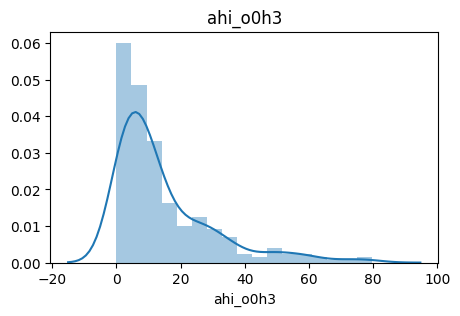

In [14]:
plt.figure(figsize=(5, 3))
sns.distplot(y, kde=True)
plt.grid(False)
plt.title("ahi_o0h3")
plt.show(block=False)

### Plot each feature distributions

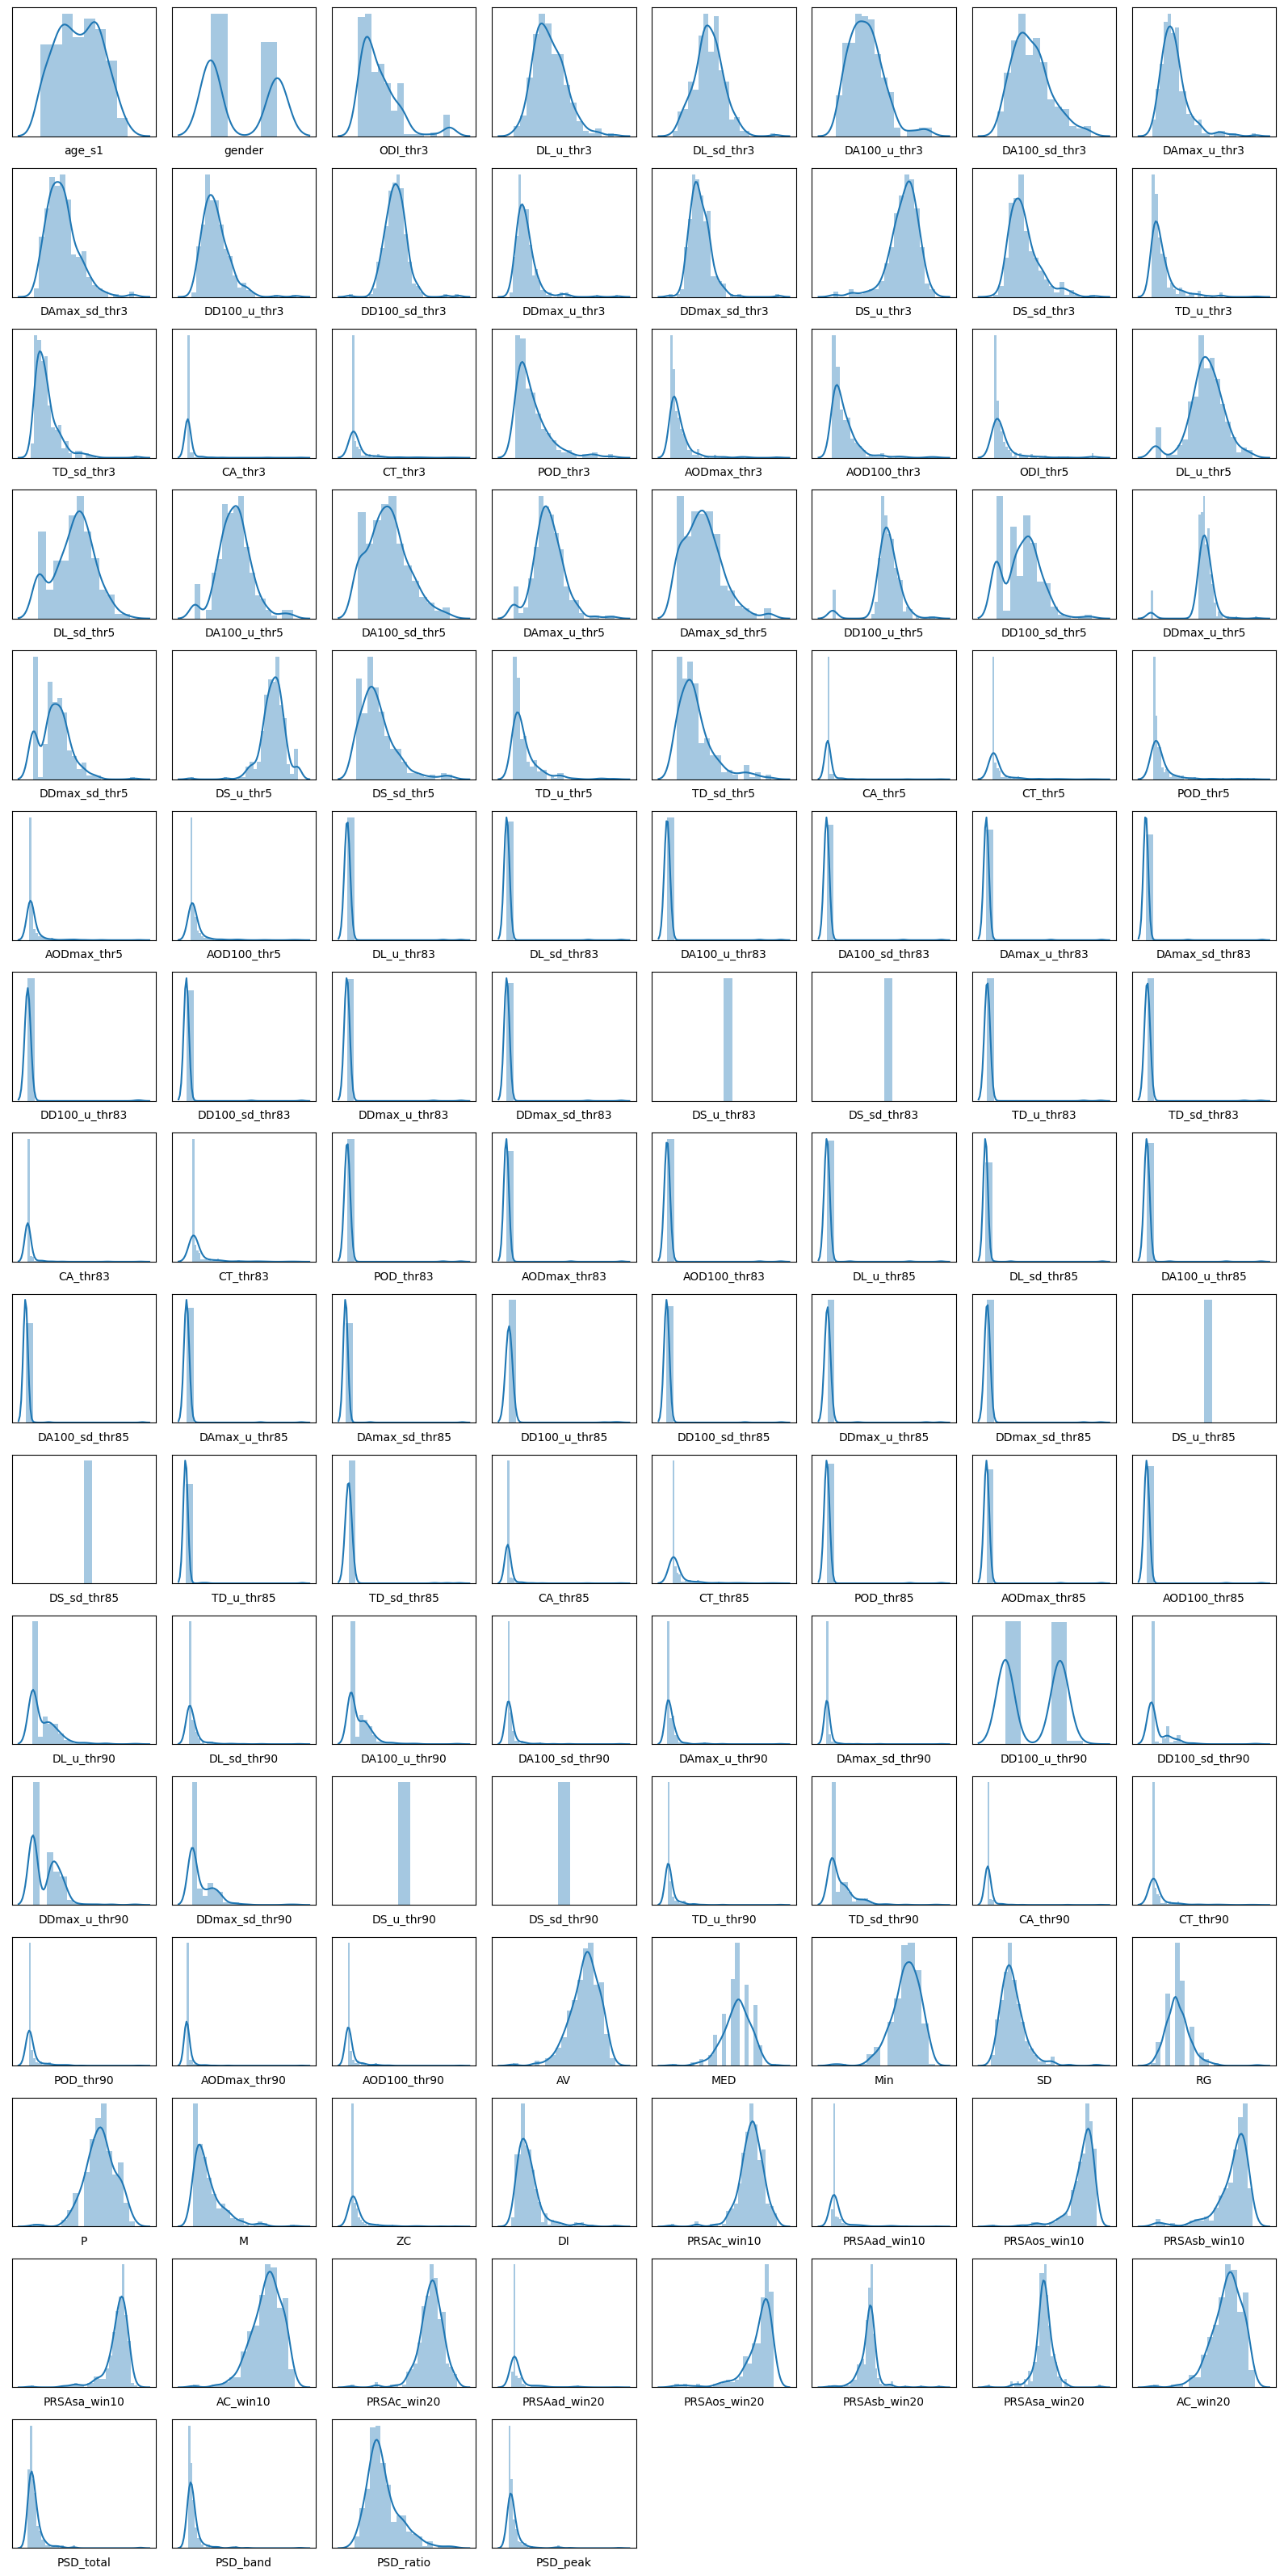

In [15]:
n_features = X.shape[1]
n_cols = 8
n_rows = (n_features // n_cols) + (1 if n_features % n_cols else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2), squeeze=False)

for i, col in enumerate(X.columns):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx]
    sns.distplot(X[col], kde=True, ax=ax)
    ax.tick_params(axis='both', which='both', labelsize=5)
    # Optionally hide x/y labels to save space:
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused subplots if any
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

### Train test split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(221, 124) (221,) (56, 124) (56,)


In [17]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

### Apply scaler

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, y_train.shape, X_train_scaled.shape, y_test.shape)

(221, 124) (221,) (221, 124) (56,)


### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

log_model = LinearRegression()
log_model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
from sklearn.metrics import mean_squared_error

y_pred = log_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))


160.1023496685464


In [21]:
cross_validation(LinearRegression, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 74.6975
Fold 1 rmse: 53.2122
Fold 2 rmse: 46.3290
Fold 3 rmse: 72.6678
Fold 4 rmse: 83.9914
Fold 5 rmse: 36.9709
Fold 6 rmse: 89.4233
Fold 7 rmse: 6417905076906691955523584.0000
Fold 8 rmse: 63.4788
Fold 9 rmse: 26.0807

Average rmse: 641790507690669222395904.0000


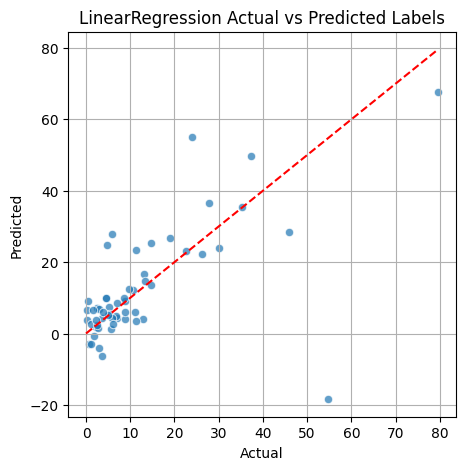

In [22]:
plot_rg(y_test, y_pred, title="LinearRegression Actual vs Predicted Labels")

sum =  1.0


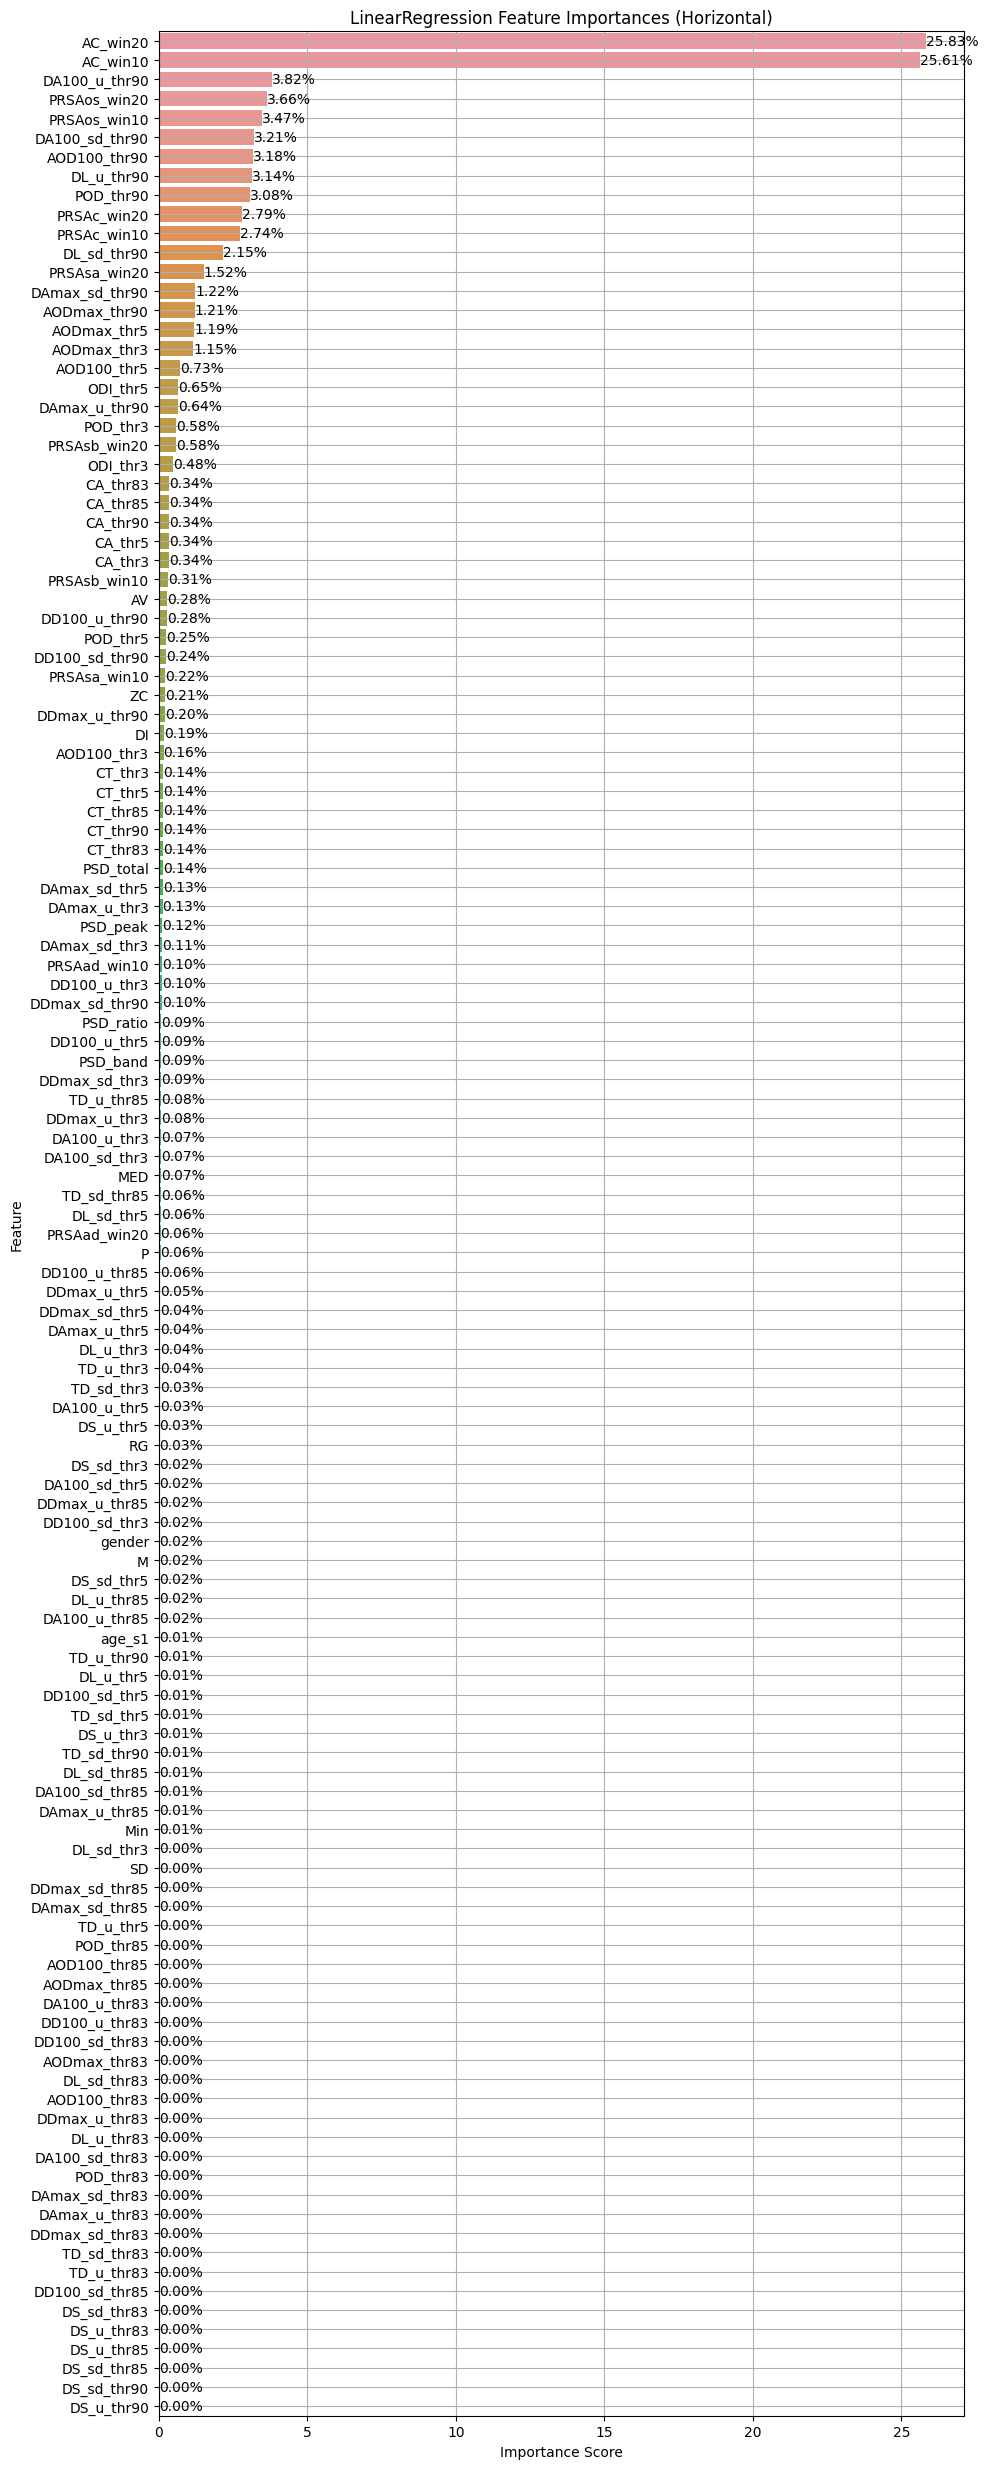

In [23]:
# Get feature importances and names
importances = abs(log_model.coef_)
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="LinearRegression Feature Importances")

### Decision Tree Regression

In [24]:
from sklearn.tree import DecisionTreeRegressor

dtree_model = DecisionTreeRegressor()
dtree_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [25]:
y_pred = dtree_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

75.72433467036477


In [26]:
cross_validation(DecisionTreeRegressor, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 83.2767
Fold 1 rmse: 71.6154
Fold 2 rmse: 37.7010
Fold 3 rmse: 39.2678
Fold 4 rmse: 72.2667
Fold 5 rmse: 48.4515
Fold 6 rmse: 53.0850
Fold 7 rmse: 143.3613
Fold 8 rmse: 56.7312
Fold 9 rmse: 58.5552

Average rmse: 66.4312


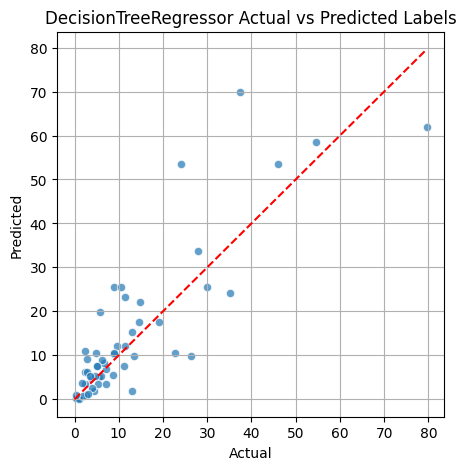

In [27]:
plot_rg(y_test, y_pred, title="DecisionTreeRegressor Actual vs Predicted Labels")

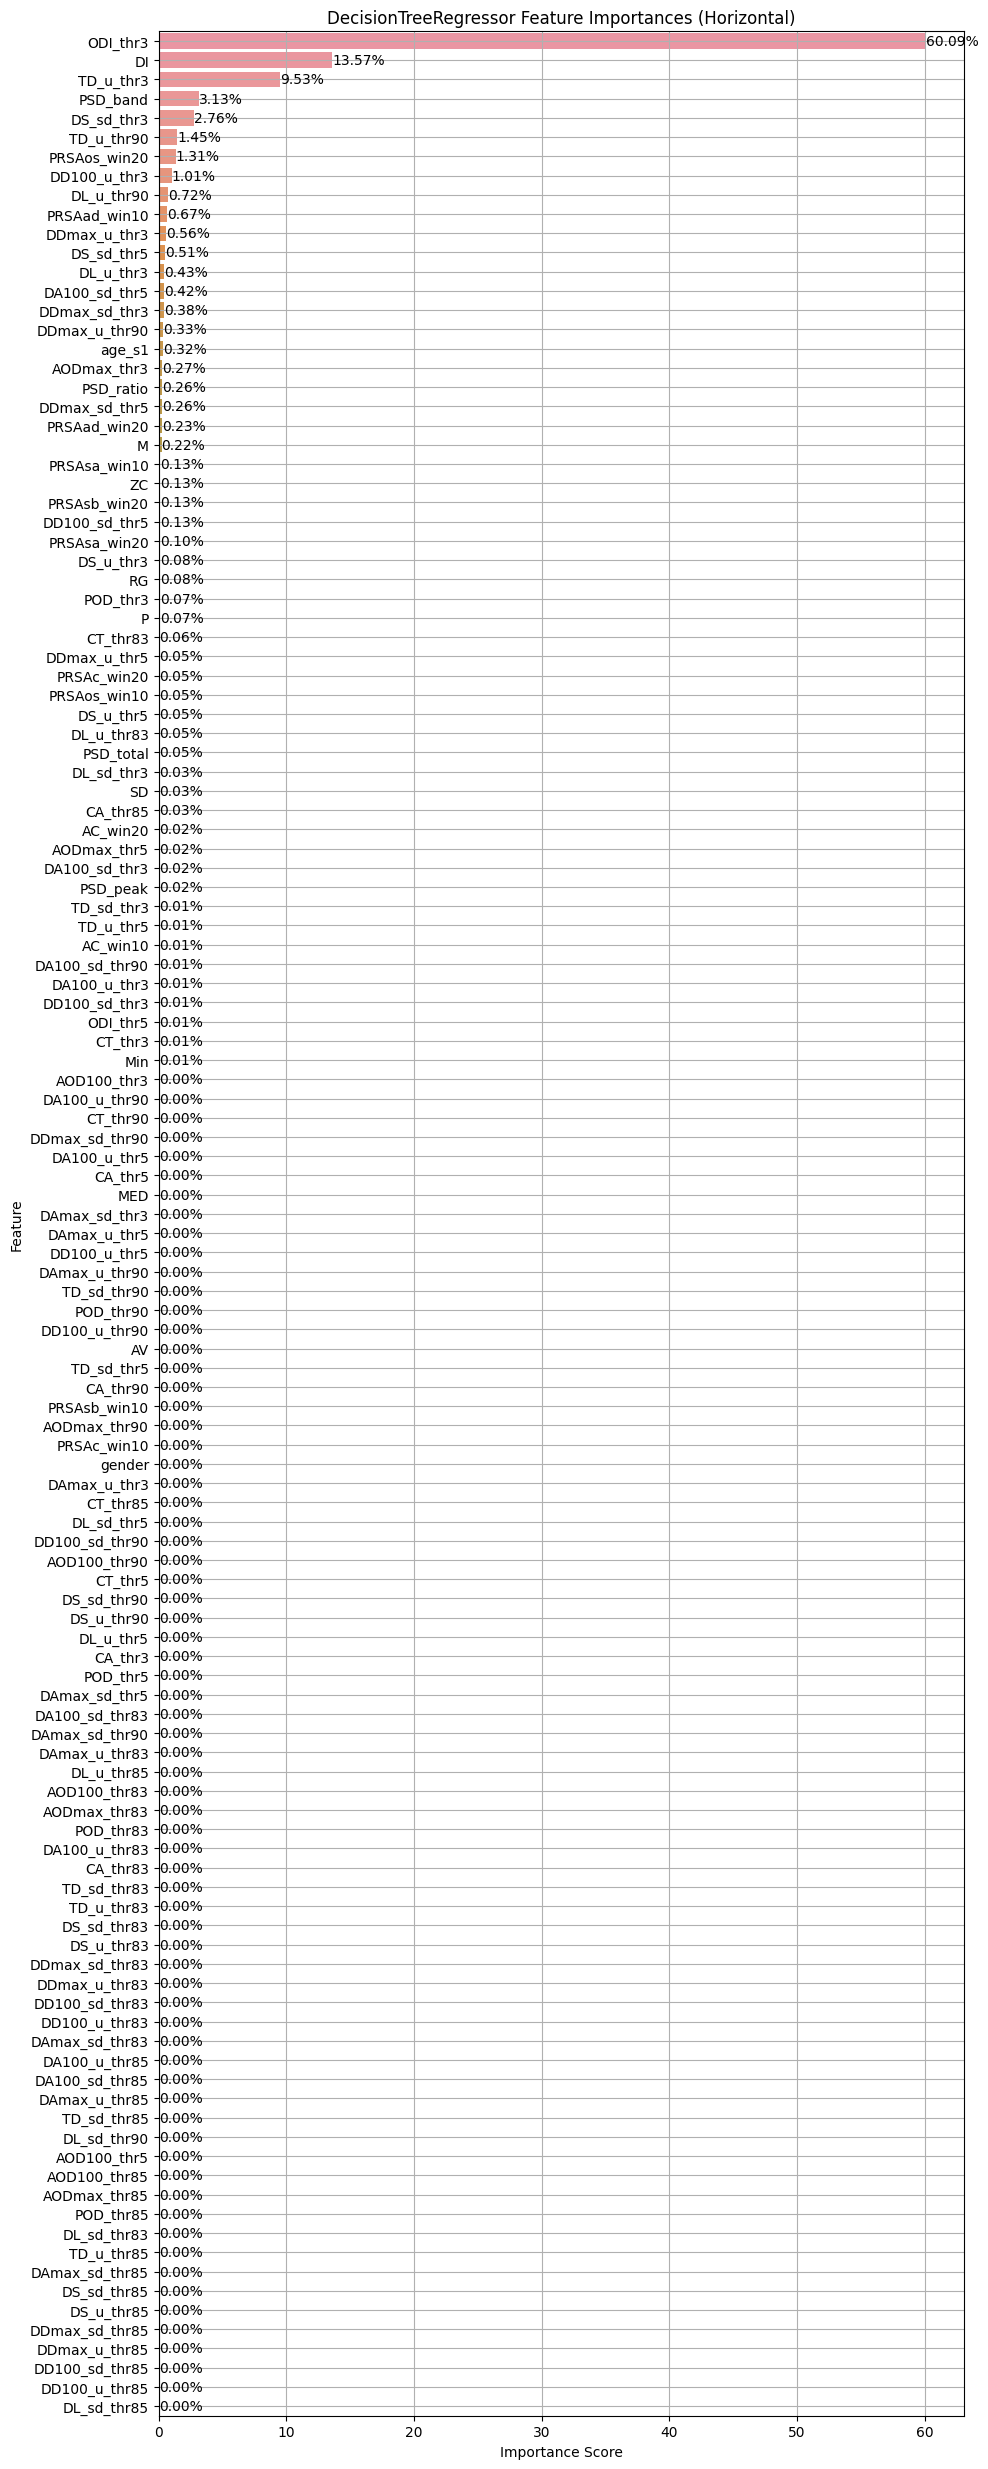

In [28]:
# Get feature importances and names
importances = dtree_model.feature_importances_
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="DecisionTreeRegressor Feature Importances")

### XBG Regression

In [29]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squarederror', ...)

In [30]:
y_pred = xgb_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

54.47059913266271


In [31]:
cross_validation(XGBRegressor, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 66.7509
Fold 1 rmse: 36.7509
Fold 2 rmse: 35.3715
Fold 3 rmse: 36.8726
Fold 4 rmse: 48.2006
Fold 5 rmse: 61.7155
Fold 6 rmse: 44.6553
Fold 7 rmse: 93.1885
Fold 8 rmse: 23.8661
Fold 9 rmse: 31.1316

Average rmse: 47.8503


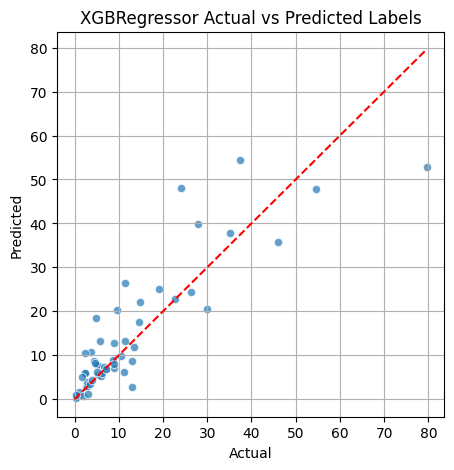

In [32]:
plot_rg(y_test, y_pred, title="XGBRegressor Actual vs Predicted Labels")

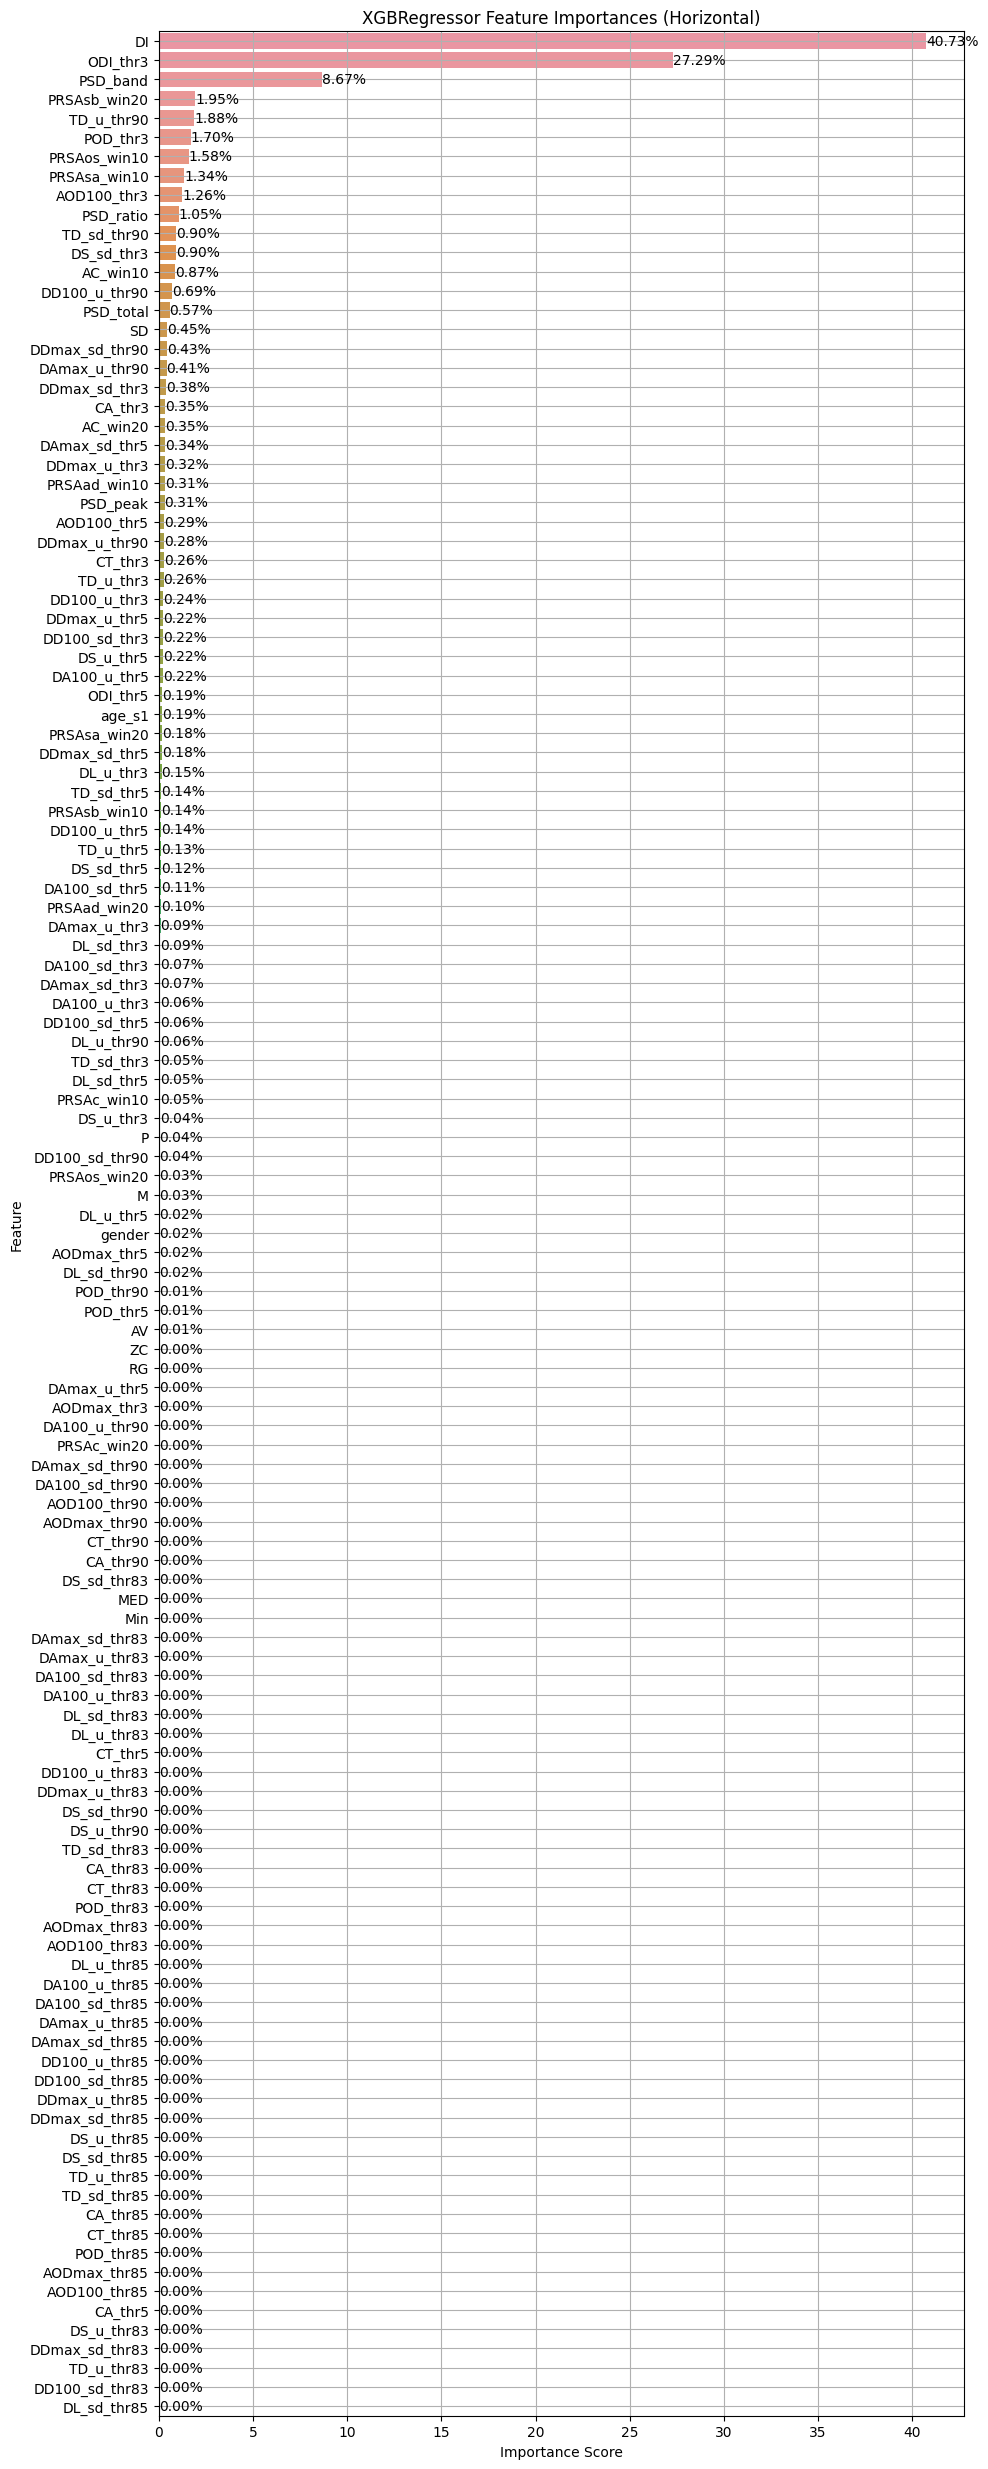

In [33]:
# Get feature importances and names
importances = xgb_model.feature_importances_
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="XGBRegressor Feature Importances")

### XGBRF Regression

In [34]:
from xgboost import XGBRFRegressor

xgbrf_model = XGBRFRegressor()
xgbrf_model.fit(X_train_scaled, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=0.8,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=1.0, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror', ...)

In [35]:
y_pred = xgbrf_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

44.31862134798088


In [36]:
cross_validation(XGBRFRegressor, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 51.3488
Fold 1 rmse: 24.7337
Fold 2 rmse: 29.5956
Fold 3 rmse: 39.9553
Fold 4 rmse: 113.4550
Fold 5 rmse: 51.4352
Fold 6 rmse: 40.3567
Fold 7 rmse: 81.2962
Fold 8 rmse: 30.2470
Fold 9 rmse: 23.8234

Average rmse: 48.6247


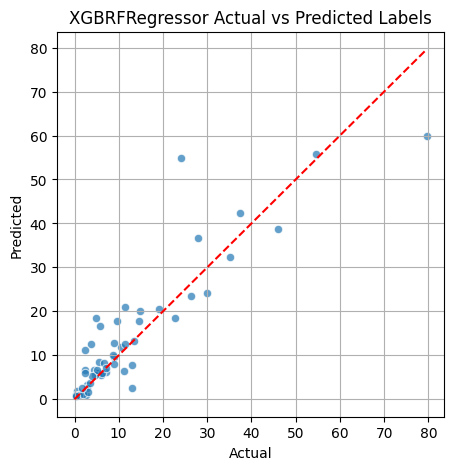

In [37]:
plot_rg(y_test, y_pred, title="XGBRFRegressor Actual vs Predicted Labels")

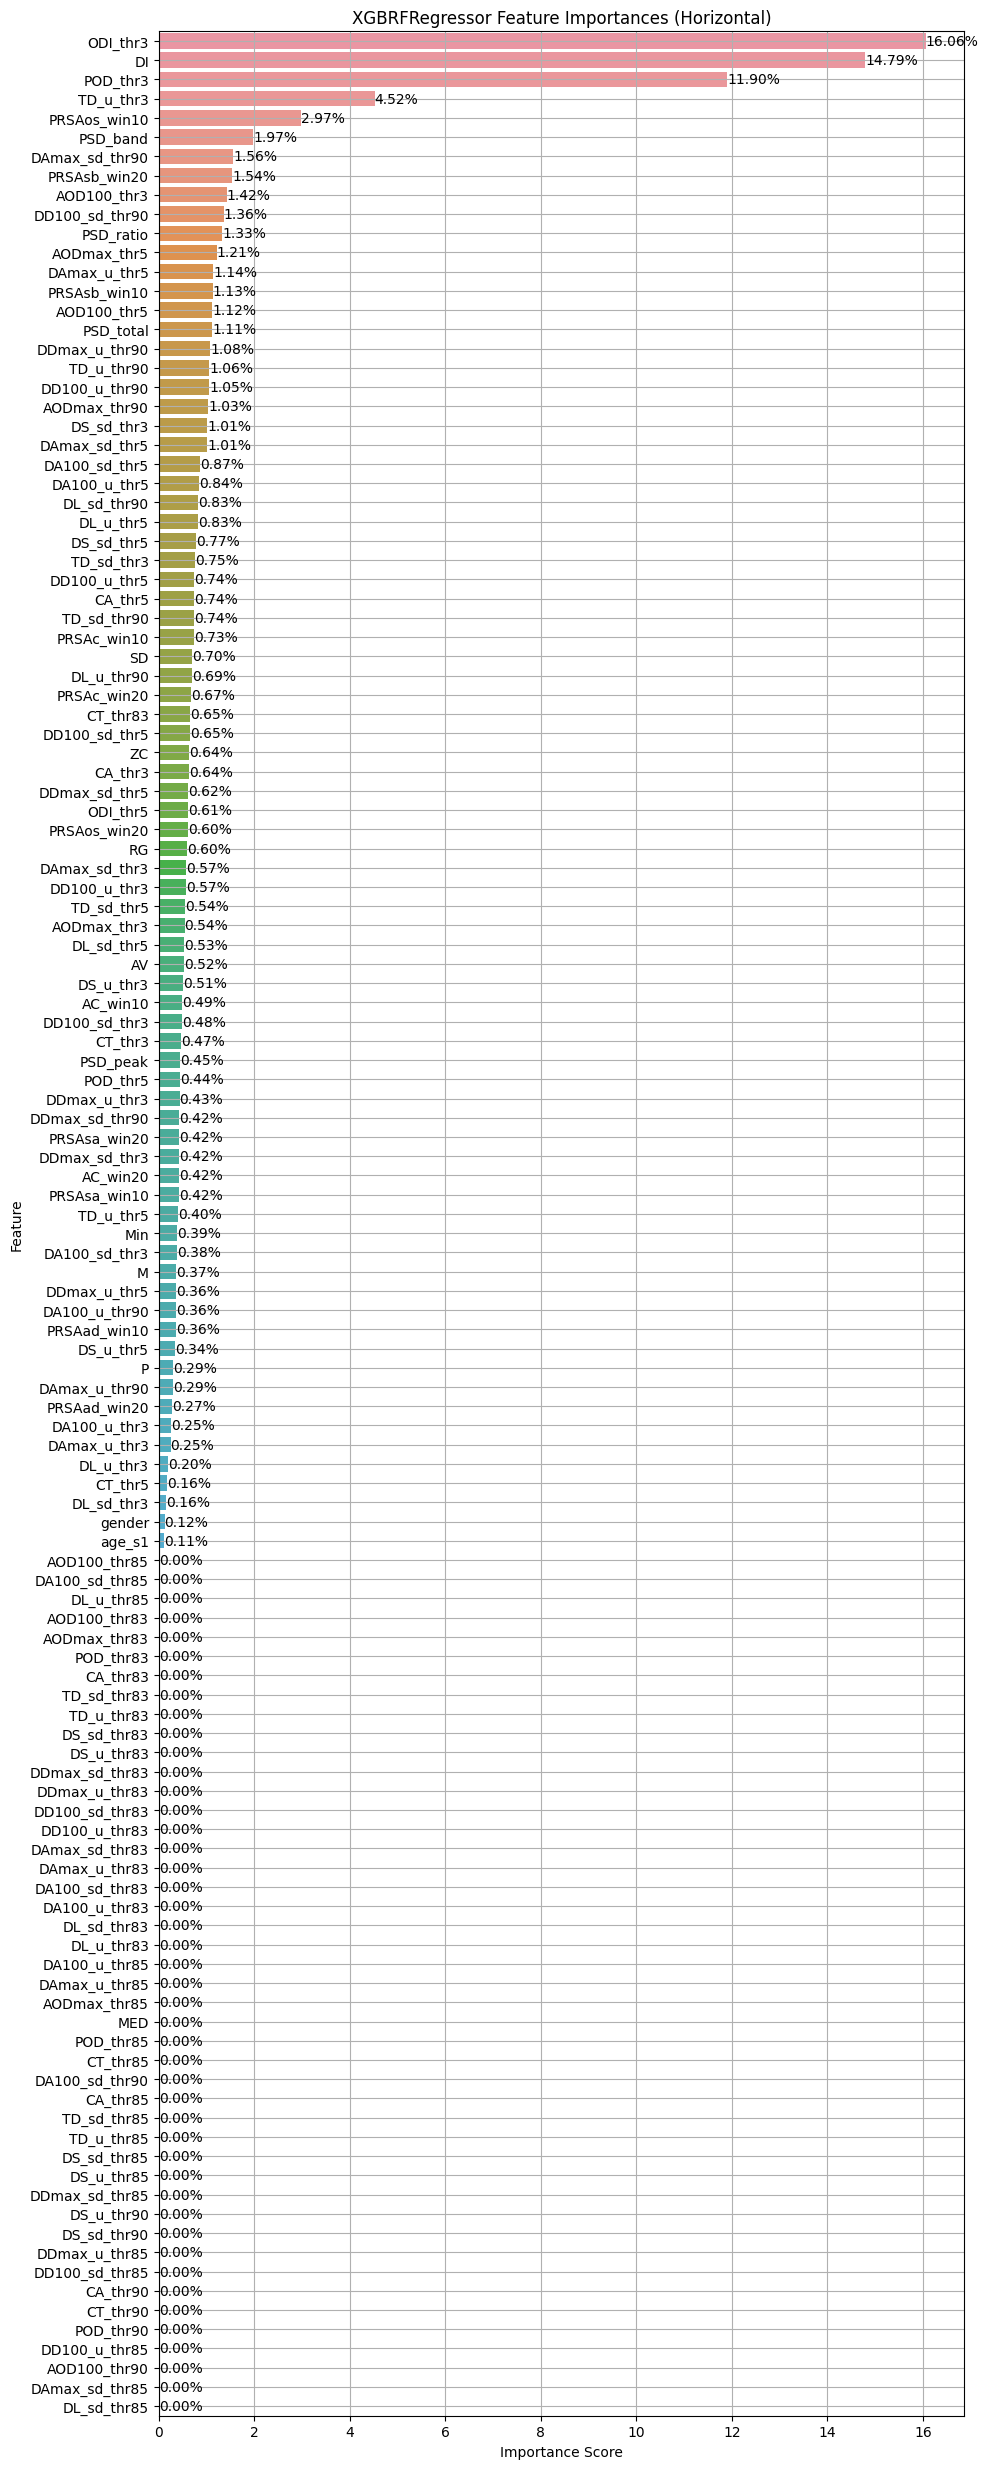

In [38]:
# Get feature importances and names
importances = xgbrf_model.feature_importances_
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="XGBRFRegressor Feature Importances")